In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import tensorflow as tf
# from keras import backend as K
import keras.backend.tensorflow_backend as K
K.set_session

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import backend as keras

from skimage.filters import threshold_yen
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import umap


Using TensorFlow backend.


In [2]:
keras.backend()

'tensorflow'

### umap test:

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
embedding = umap.UMAP().fit_transform(digits.data)

### start resarch:

In [4]:
os.getcwd()
TRAIN_PATH = "data/stage1_train/"
TEST_PATH = "data/stage1_test/"
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

## Train data loader function

In [6]:

def load_train_data(number_of_img=None):
    X_train_ = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train_ = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    sys.stdout.flush()
    print('Getting and resizing train images and masks ... ')
    enumerate_coll = tqdm(enumerate(train_ids), total=len(train_ids))
    for n, id_ in enumerate_coll:
        if number_of_img and number_of_img == n:
            break
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train_[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train_[n] = mask
    return X_train_, Y_train_


In [7]:
X, Y = load_train_data()

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [03:31<00:00,  3.16it/s]


In [8]:
split_th = round(len(train_ids)*0.85)

In [9]:
X_train = X[:split_th]
Y_train = Y[:split_th]
X_test = X[split_th:]
Y_test = Y[split_th:]
number_of_train_samples = len(X_train)
number_of_test_samples = len(X_test)
print("number of train samples: ", number_of_train_samples, "  number of test samples: ", number_of_test_samples)

number of train samples:  570   number of test samples:  100


In [10]:
def simple_iou(component1,component2):
    overlap = component1*component2 # Logical AND
    union = component1 + component2 # Logical OR
    union = (union > 0).astype(np.uint8)
    IOU = overlap.sum()/float(union.sum())
    return IOU

### Plot Data

In [11]:
def remove_axis(ax):
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return

In [366]:
def plot_original_data(x_data = X_train, y_data = Y_train, number_of_img=10):
    f, axarr = plt.subplots(2,number_of_img,figsize=(15,6))
    for i in range(0,number_of_img):   
        axarr[0,i].imshow(x_data[i])
        axarr[1,i].imshow(np.squeeze(y_data[i]))
        for j in range(0,2):
            remove_axis(axarr[j,i])

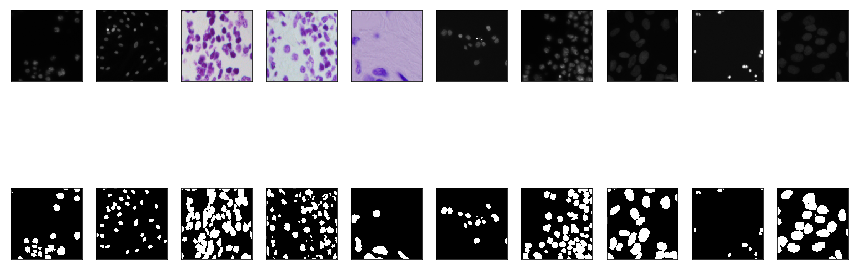

In [367]:
plot_original_data()

## Thresholding Method

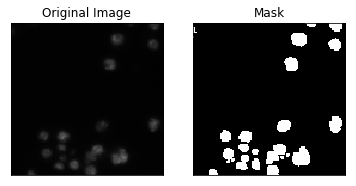

In [368]:
f, axarr = plt.subplots(1,2,figsize=(6,5))
axarr[0].imshow(X_train[0])
axarr[1].imshow(np.squeeze(Y_train[0]))
remove_axis(axarr[0])
remove_axis(axarr[1])
axarr[0].set_title("Original Image")
axarr[1].set_title("Mask")

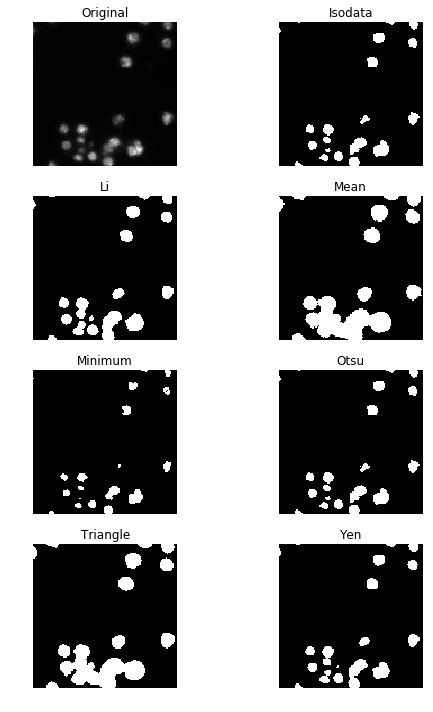

In [369]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(X_train[0][:, :, 0], figsize=(8, 10), verbose=False)
plt.show()

### Threshold Yen

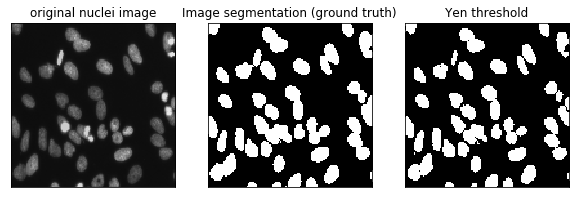

In [370]:
from skimage.filters import threshold_yen

def plot_threshold_yen(i=0):
    image = X_test[i][:, :, 0]
    thresh = threshold_yen(image)
    binary = np.array( image > thresh, dtype=int)
    f, axarr = plt.subplots(1,3,figsize=(10,8))
    axarr[0].imshow(X_test[i])
    axarr[0].set_title("original nuclei image")
    axarr[1].imshow(binary)
    axarr[1].set_title("Image segmentation (ground truth)")
    axarr[2].imshow(np.squeeze(Y_test[i]))
    axarr[2].set_title("Yen threshold")
    for i in range(0,3):
        remove_axis(axarr[i])

plot_threshold_yen()

In [371]:
image = X_test[0][:, :, 0]
thresh = threshold_yen(image)
binary = np.array( image > thresh, dtype=int)
simple_iou(binary,np.squeeze(Y_test[0]))

0.89515219842164595

In [372]:
iou_sum = 0
len1 = 0
for i in range(0,100):
    image = X_test[i][:, :, 0]
    thresh = threshold_yen(image)
    binary = np.array( image > thresh, dtype=int)
    iou_sum += simple_iou(binary,np.squeeze(Y_test[i]))
    len1 += 1
print(iou_sum/ len1, len1)

0.679356069722 100


## Show IoU idea

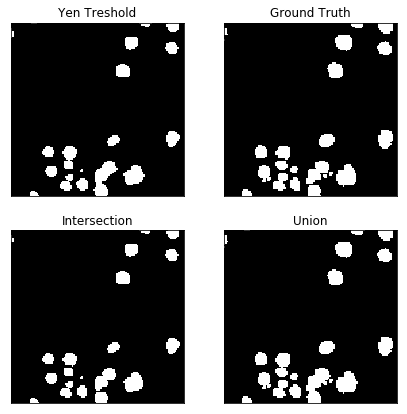

In [373]:

image = X_train[0][:, :, 0]
thresh = threshold_yen(image)
component1 = np.array( image > thresh, dtype=int)
component2 = np.squeeze(Y_train[0])

overlap = component1*component2
iou = component1 + component2
union = (iou > 0).astype(np.uint8)

f, axarr = plt.subplots(2,2,figsize=(7,7))
axarr[0,0].set_title("Yen Treshold")
axarr[0,0].imshow(component1)
axarr[0,1].set_title("Ground Truth")
axarr[0,1].imshow(component2)
axarr[1,0].set_title("Intersection")
axarr[1,0].imshow(overlap)
axarr[1,1].set_title("Union")
axarr[1,1].imshow(union)

for i in range(0,2):
    for j in range(0,2):
        remove_axis(axarr[i,j])


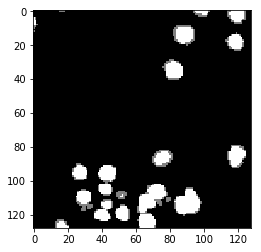

In [374]:
plt.imshow(iou)

# KERAS Models

### models names:

In [74]:
FCN_model_name = 'FCN-v1'
Unet_model_name = 'U-net-v1'
large_Unet_model_name = 'large-U-net-v1'

In [75]:
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.1
EPOCHS = 100
START_LR = 1e-3
END_LR = 1e-4

### calc learning rate decay step:

In [76]:
number_of_updates = round(round(number_of_train_samples*(1-VALIDATION_SPLIT))*EPOCHS/BATCH_SIZE)
LR_DECAY = (START_LR - END_LR)/number_of_updates
LR_DECAY

1.40361821584529e-07

### model default training:

In [77]:
def train_keras_model(model, model_name, epochs_= EPOCHS):
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(X_train, Y_train, 
                        validation_split=VALIDATION_SPLIT, 
                        batch_size=BATCH_SIZE, 
                        epochs=epochs_, 
                        verbose=0,
                        callbacks=[earlystopper, checkpointer])
    return results

## FCN

In [203]:
def FCN_v1(input_size = (128,128,3)):
    inputs = Input(input_size)
    conv = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     drop = Dropout(0.25)(conv)
#     conv = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop)
    conv = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(1, 1, activation = 'sigmoid')(conv)
    model = Model(input = inputs, output = conv)
    return model 

In [204]:
FCN_v1().summary()

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_357 (Conv2D)          (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_358 (Conv2D)          (None, 128, 128, 8)       584       
_________________________________________________________________
conv2d_359 (Conv2D)          (None, 128, 128, 4)       292       
_________________________________________________________________
conv2d_360 (Conv2D)          (None, 128, 128, 2)       74        
_________________________________________________________________
conv2d_361 (Conv2D)          (None, 128, 128, 1)       3         
Total params: 1,177
Trainable params: 1,177
Non-trainable params: 0
_________________________________________________________________


In [205]:
model = FCN_v1()
model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
train_keras_model(model, FCN_model_name, epochs_=100)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 00000: val_loss improved from inf to 0.67366, saving model to FCN-v1.h5
Epoch 00001: val_loss improved from 0.67366 to 0.65283, saving model to FCN-v1.h5
Epoch 00002: val_loss improved from 0.65283 to 0.63394, saving model to FCN-v1.h5
Epoch 00003: val_loss improved from 0.63394 to 0.61634, saving model to FCN-v1.h5
Epoch 00004: val_loss improved from 0.61634 to 0.60004, saving model to FCN-v1.h5
Epoch 00005: val_loss improved from 0.60004 to 0.58541, saving model to FCN-v1.h5
Epoch 00006: val_loss improved from 0.58541 to 0.57172, saving model to FCN-v1.h5
Epoch 00007: val_loss improved from 0.57172 to 0.55907, saving model to FCN-v1.h5
Epoch 00008: val_loss improved from 0.55907 to 0.54743, saving model to FCN-v1.h5
Epoch 00009: val_loss improved from 0.54743 to 0.53674, saving model to FCN-v1.h5
Epoch 00010: val_loss improved from 0.53674 to 0.52685, saving model to FCN-v1.h5
Epoch 00011: val_loss improved from 0.52685 to 0.51762, saving model to FCN-v1.h5
Epoch 00012: val_los

## U-net

In [86]:

def Contracting(inputs, dim):
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv )
    return pool , conv

def Expansive(inputs, parallel_conv, dim):
    up = Conv2D(dim, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(inputs))
    
    merge_l = concatenate([parallel_conv,up], axis=3)
#     merge_l = merge([parallel_conv,up], mode = 'concat', concat_axis = 3)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_l)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    return conv

def Conv_n_Dropout(inputs, dim):
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    drop = Dropout(0.5 ,  name='decoder')(conv)
    return drop
    

In [245]:
def unet(input_size = (128,128,3)):
    """
    this is an my implementation for U-net with keras
    the original imput shape was 256x256x1 -> 64 ->128 ->512 -> 1024, 
    i used 128x128x3 -> 4 ->8 -> 16 ->32 in order to test it on my own cpu 
    i also excluded one pooling group 
    """
    inputs = Input(input_size)
    contract4, conv4 = Contracting(inputs, 4)
    contract8, conv8 = Contracting(contract4, 8)
    contract16, conv16 = Contracting(contract8, 16)
    convolve_n_drop32 = Conv_n_Dropout(contract16, 32)
    expan16 = Expansive(convolve_n_drop32, conv16, 16)
    expan8 = Expansive(expan16, conv8, 8)
    expan4 = Expansive(expan8, conv4, 4)
    
    conv2 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    model = Model(inputs = inputs, outputs = conv1)

    return model

In [253]:
model = unet()
model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "{}_LR_DECAY_from_{}_to_{}.h5".format(Unet_model_name, START_LR, END_LR)
print(model_name)
train_keras_model(model,model_name, epochs_=100)

U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00000: val_loss improved from inf to 0.30739, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.30739 to 0.26827, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.26827 to 0.22208, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss improved from 0.22208 to 0.21183, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00005: val_loss improved from 0.21183 to 0.20723, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00006: val_loss improved from 0.20723 to 0.20297, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00007: val_loss improved from 0.20297 to 0.20207, saving model to U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.20207 to 0.2

## large unet Model

In [87]:
def large_unet(input_size = (128,128,3)):
    """
    this is an my implementation for U-net with keras
    the original imput shape was 256x256x1 -> 64 ->128 ->512 -> 1024, 
    i used 128x128x3 -> 4 ->8 -> 16 ->32 -> 64 in order to test it on my own cpu 
    """
    inputs = Input(input_size)
    lambda1 = Lambda(lambda x: x / 255) (inputs)
    contract4, conv4 = Contracting(lambda1, 4)
    contract8, conv8 = Contracting(contract4, 8)
    contract16, conv16 = Contracting(contract8, 16)
    contract32, conv32 = Contracting(contract16, 32)
    convolve_n_drop64 = Conv_n_Dropout(contract32, 64)
    expan32 = Expansive(convolve_n_drop64, conv32, 32)
    expan16 = Expansive(expan32, conv16, 16)
    expan8 = Expansive(expan16, conv8, 8)
    expan4 = Expansive(expan8, conv4, 4)
    
    conv2 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    autoencoder = Model(input = inputs, output = conv1)
    
    encoder = Model(inputs, convolve_n_drop64)
    
    print([x.name for x in autoencoder.layers])
    # create a placeholder for an encoded input
    encoded_input = Input(shape= (8, 8, 64), name="encoded_input")
    decoder_layer = autoencoder.get_layer("decoder")
    decoder = Model(encoded_input, decoder_layer(encoded_input), name="decoder")
    
    return autoencoder, encoder, decoder

In [383]:
model, encoder, decoder = large_unet()

model.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "{}_LR_DECAY_from_{}_to_{}.h5".format(large_Unet_model_name, START_LR, END_LR)

train_keras_model(model, model_name, epochs_=100)

decoder.save("decoder_{}".format(model_name))
encoder.save("encoder_{}".format(model_name))

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


['input_28', 'lambda_17', 'conv2d_491', 'conv2d_492', 'max_pooling2d_83', 'conv2d_493', 'conv2d_494', 'max_pooling2d_84', 'conv2d_495', 'conv2d_496', 'max_pooling2d_85', 'conv2d_497', 'conv2d_498', 'max_pooling2d_86', 'conv2d_499', 'conv2d_500', 'decoder', 'up_sampling2d_75', 'conv2d_501', 'concatenate_75', 'conv2d_502', 'conv2d_503', 'up_sampling2d_76', 'conv2d_504', 'concatenate_76', 'conv2d_505', 'conv2d_506', 'up_sampling2d_77', 'conv2d_507', 'concatenate_77', 'conv2d_508', 'conv2d_509', 'up_sampling2d_78', 'conv2d_510', 'concatenate_78', 'conv2d_511', 'conv2d_512', 'conv2d_513', 'conv2d_514']
Epoch 00000: val_loss improved from inf to 0.46044, saving model to large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from 0.46044 to 0.41474, saving model to large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss improved from 0.41474 to 0.33229, saving model to large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00003: val_loss improved from 0.3

## Model Evaluation Utils

In [108]:
def find_best_threshold(pred_data, compared_data):
    if len(pred_data) != len(compared_data):
        raise Exception("invalid compared shapes, {} != {}".format(len(pred_data),len(compared_data)))
    thresholds = []
    for i in range(0,len(pred_data)):
        best_t = 0
        best_iou = 0
        for t in np.linspace(0,1,101):
            iou = simple_iou(np.squeeze(pred_data[i]> t),np.squeeze(compared_data[i]))
            if iou > best_iou:
                best_iou = iou
                best_t = t
        thresholds.append(best_t)
    return sum(thresholds) / float(len(thresholds))

In [109]:
def get_threshold():
    best_train_th = find_best_threshold(preds_train, Y_train)
    best_test_th = find_best_threshold(preds_test, Y_test)
    print("train threshold: " , best_train_th, " test threshold: ", best_test_th )
    if  best_train_th - best_test_th > 0.001:
        print("WARNING: model best threshold is not efficient, bias: {}".format(best_train_th - best_test_th))
    return best_train_th, best_test_th

In [110]:
def predict_segmentetion_plot(model_name, number_of_plots = 3):
    f, axarr = plt.subplots(number_of_plots ,4,figsize=(15.5,10))
    for i in range(0,number_of_plots):
        axarr[i,0].imshow(X_test[i])
        axarr[i,1].imshow(np.squeeze(Y_test[i]))
        axarr[i,2].imshow(np.squeeze(preds_test[i]))
        axarr[i,3].imshow(np.squeeze(preds_test_th[i]))
        for j in range(0,4):
            remove_axis(axarr[i,j])
            
        axarr[0,0].set_title("Original nuclei image")
        axarr[0,1].set_title("Image segmentation (ground truth)")
        axarr[0,2].set_title(model_name)
        axarr[0,3].set_title("Clean {}".format(model_name))
    
    return f, axarr

In [111]:
def get_model_mean_iou():
    iou_sum = 0
    len1 = 0
    for i in range(0,len(Y_test)):
        iou_sum += simple_iou(np.squeeze(preds_test_th[i]),np.squeeze(Y_test[i]))
        len1 += 1
    print("mean test IOU: ", iou_sum/ len1, " number of samples: ", len1)
    
    iou_sum = 0
    len1 = 0
    for i in range(0,len(Y_train)):
        iou_sum += simple_iou(np.squeeze(preds_train_th[i]),np.squeeze(Y_train[i]))
        len1 += 1
    print("mean train IOU: ", iou_sum/ len1, " number of samples: ", len1)
    

## Predict on FCN

In [399]:
model = load_model("FCN-v1.h5")
preds_test = model.predict(X_test, verbose=1)
preds_train = model.predict(X_train, verbose=1)

570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s     


In [405]:
best_train_th, best_test_th =  get_threshold()
best_th = best_test_th

train threshold:  0.391140350877  test threshold:  0.3991


In [406]:
preds_train_th = (preds_train > best_th).astype(np.uint8)
preds_test_th = (preds_test > best_th).astype(np.uint8)

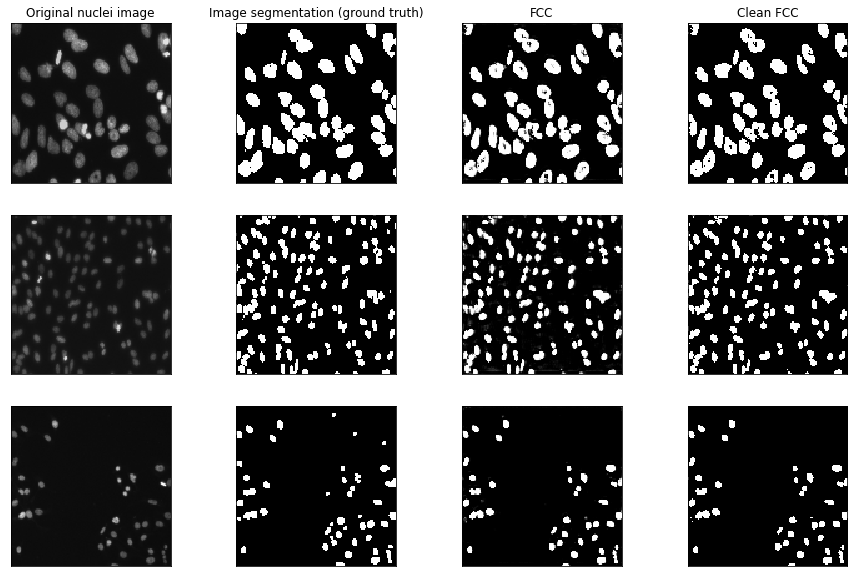

In [407]:
f, axarr = predict_segmentetion_plot(model_name = "FCC")

In [408]:
simple_iou(np.squeeze(preds_test_th[0]),np.squeeze(Y_test[0]))

0.89253231211105788

In [409]:
get_model_mean_iou()

mean test IOU:  0.789565065228  number of samples:  100
mean train IOU:  0.76762676382  number of samples:  570


## Predict on Unet

In [426]:
# model = load_model("{}.h5".format(Unet_model_name))
test_model_name = "U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5"
model = load_model(test_model_name)
preds_test = model.predict(X_test, verbose=1)
preds_train = model.predict(X_train, verbose=1)

570/570 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s    


In [427]:
best_train_th, best_test_th =  get_threshold()
best_th = best_test_th

train threshold:  0.36901754386  test threshold:  0.3797


In [428]:
preds_train_th = (preds_train > best_th).astype(np.uint8)
preds_test_th = (preds_test > best_th).astype(np.uint8)

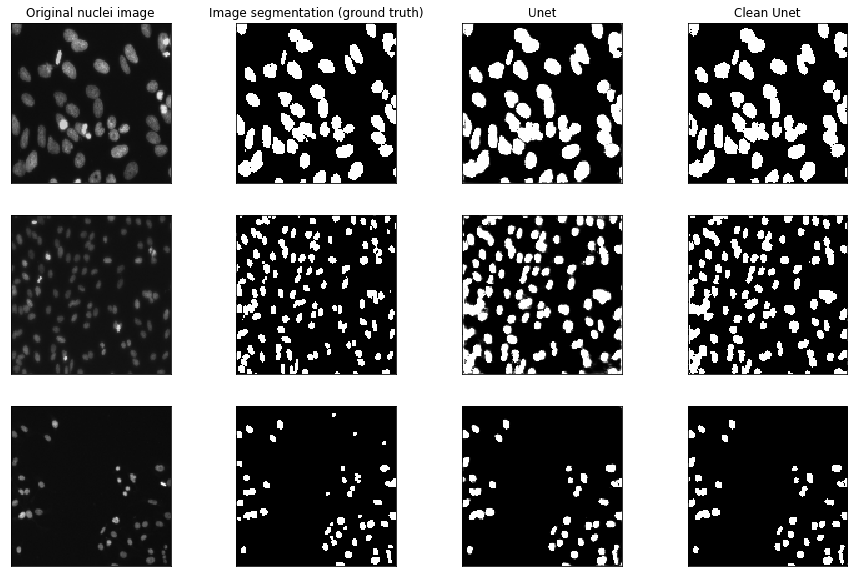

In [429]:
f, axarr = predict_segmentetion_plot(model_name = "Unet")

In [430]:
simple_iou(np.squeeze(preds_test_th[0]),np.squeeze(Y_test[0]))

0.87074679628811313

In [431]:
get_model_mean_iou()

mean test IOU:  0.753670445168  number of samples:  100
mean train IOU:  0.698591023399  number of samples:  570


## Predict on large Unet

In [454]:
model = load_model("{}.h5".format((large_Unet_model_name)))
# model = load_model(model_name)

preds_test = model.predict(X_test, verbose=1)
preds_train = model.predict(X_train, verbose=1)

570/570 [==============================] - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 11s    


In [455]:
best_train_th, best_test_th =  get_threshold()
best_th = best_test_th

train threshold:  0.431614035088  test threshold:  0.4281


In [456]:
preds_train_th = (preds_train > best_th).astype(np.uint8)
preds_test_th = (preds_test > best_th).astype(np.uint8)

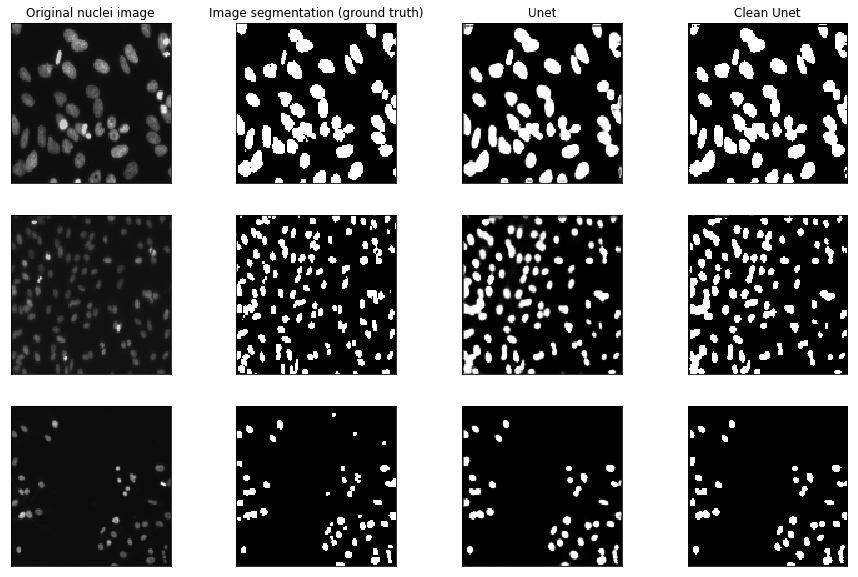

In [457]:
f, axarr = predict_segmentetion_plot(model_name = "Unet")

In [458]:
simple_iou(np.squeeze(preds_test_th[0]),np.squeeze(Y_test[0]))

0.87379779498006094

In [459]:
get_model_mean_iou()

mean test IOU:  0.7745620593  number of samples:  100
mean train IOU:  0.769377919875  number of samples:  570


# Investigating Encoding

In [12]:
encoder = load_model("encoder_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5")

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [31]:
encoded_imgs = encoder.predict(X_train)
# decoded_imgs = decoder.predict(encoded_imgs)

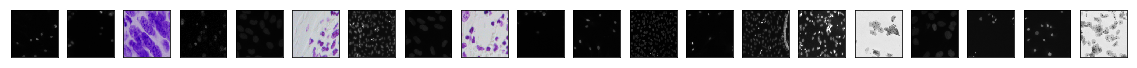

In [32]:
n = 20
f, axarr = plt.subplots(1,n,figsize=(20,10))
for i in range(n):
    index = i + 50
    a = encoded_imgs[index].reshape(32, 128).T
    axarr[i].imshow(X_train[index])
    remove_axis(axarr[i])

plt.show()

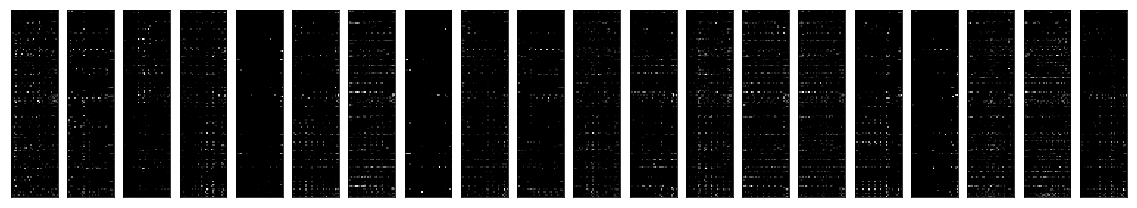

In [33]:
n = 20
f, axarr = plt.subplots(1,n,figsize=(20,10))
for i in range(n):
    index = i + 50
    a = encoded_imgs[index].reshape(32, 128).T
    axarr[i].imshow(a)
    remove_axis(axarr[i])

plt.show()

In [34]:
encoded_imgs.shape

(570, 8, 8, 64)

In [59]:
embedding = umap.UMAP().fit_transform([x.reshape(4096) for x in encoded_imgs])

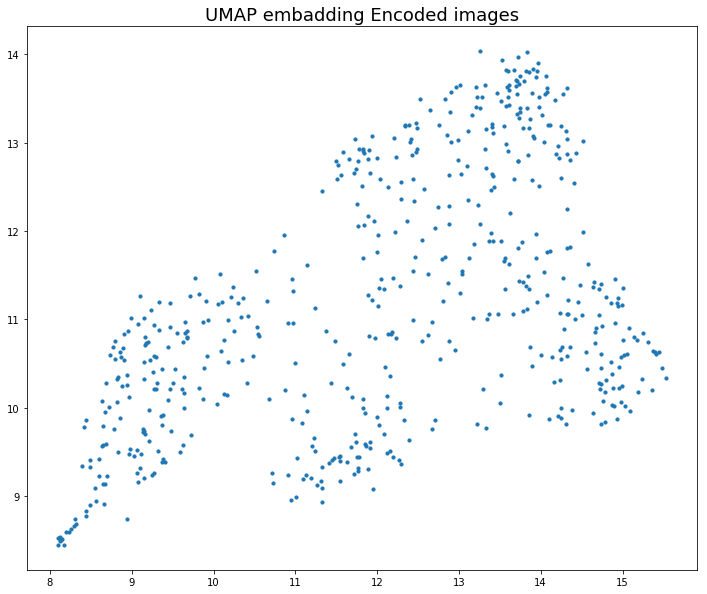

In [60]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
plt.title("UMAP embadding Encoded images", fontsize=18)
plt.show()

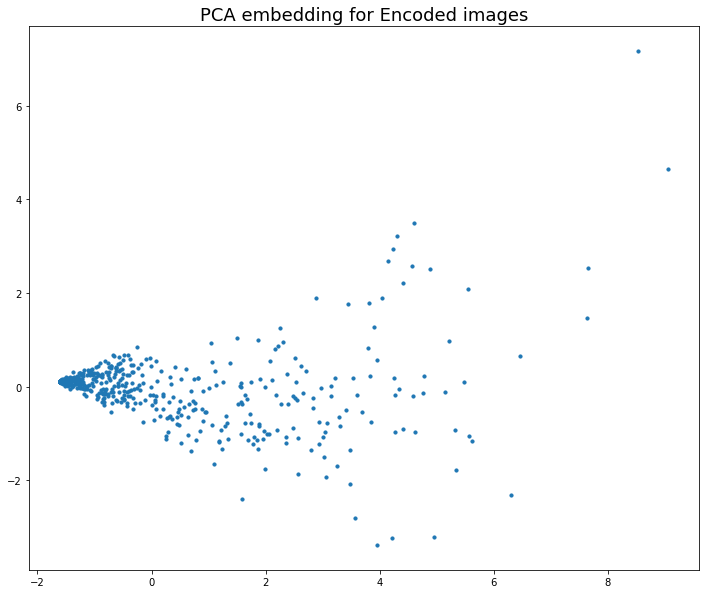

In [61]:
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform([x.reshape(4096) for x in encoded_imgs])
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], s=10)
plt.title("PCA embedding for Encoded images", fontsize=18)
plt.show()

In [66]:
db = DBSCAN(eps=0.3, min_samples=7).fit(embedding)

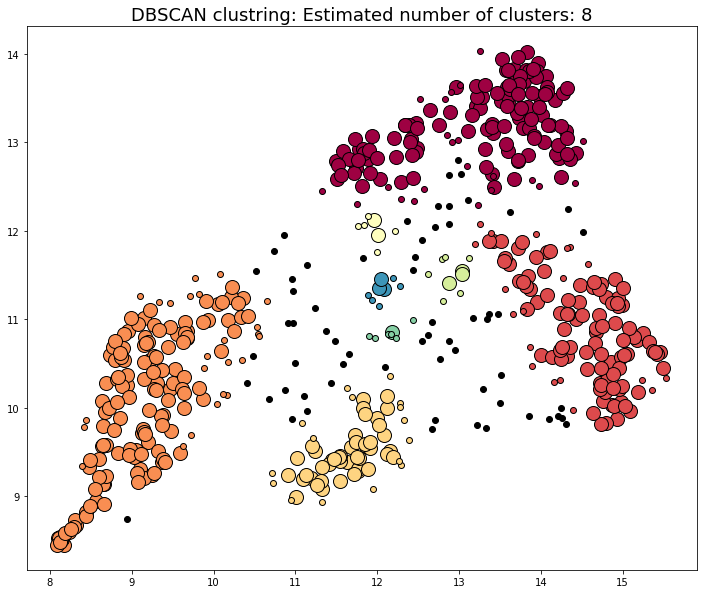

In [67]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
fig, ax = plt.subplots(figsize=(12, 10))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = embedding[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = embedding[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN clustring: Estimated number of clusters: %d' % n_clusters_, fontsize=18)
plt.show()

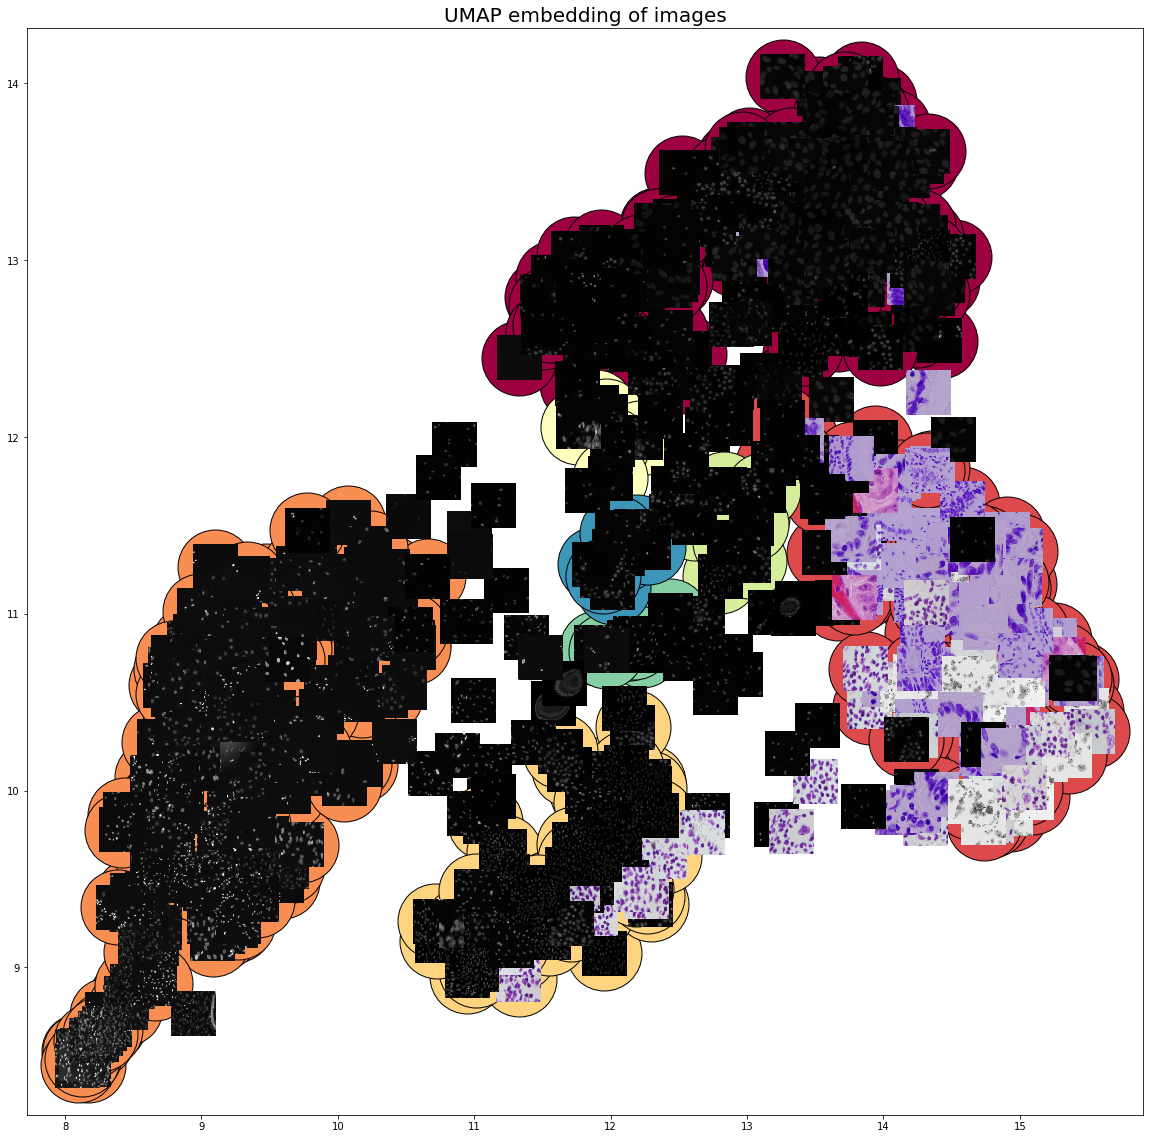

In [68]:
def scatter_images_plot(images, X):

    def imscatter(x, y, images, ax=None, zoom=1.0):
        if ax is None:
            ax = plt.gca()
        x, y = np.atleast_1d(x, y)
        artists = []
        for x0, y0, img0 in zip(x, y, images):
            im = offsetbox.OffsetImage(img0, zoom=zoom)
            ab = offsetbox.AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        return artists

    def plot_embedding(X, imgs):
        fig, ax = plt.subplots(figsize=(20, 20))
        ax = plt.subplot(111)
        for i in range(X.shape[0]):
            plt.text(X[i, 0], X[i, 1], ".", fontdict={'weight': 'bold', 'size': 9})
        if hasattr(offsetbox, 'AnnotationBbox'):
            imscatter(X[:,0], X[:,1], imgs, zoom=0.35, ax=ax)
            

    plot_embedding(embedding, X_train)
    plt.title("UMAP embedding of images", fontsize=20)
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            continue
        class_member_mask = (labels == k)
        xy = embedding[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=75)


scatter_images_plot(X_train, embedding)

# Convolutional autoencoder

In [98]:
def train_autoencoder_keras_model(model, model_name, epochs_= EPOCHS):
    earlystopper = EarlyStopping(patience=30, verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(X_train, X_train, 
                        validation_split=VALIDATION_SPLIT, 
                        batch_size=BATCH_SIZE, 
                        epochs=epochs_, 
                        verbose=0,
                        callbacks=[earlystopper, checkpointer])
    return results

In [99]:
def ae_large_unet(input_size = (128,128,3)):
    """
    this is an my implementation for U-net with keras
    the original imput shape was 256x256x1 -> 64 ->128 ->512 -> 1024, 
    i used 128x128x3 -> 4 ->8 -> 16 ->32 -> 64 in order to test it on my own cpu 
    """
    inputs = Input(input_size)
    lambda1 = Lambda(lambda x: x / 255) (inputs)
    contract4, conv4 = Contracting(lambda1, 4)
    contract8, conv8 = Contracting(contract4, 8)
    contract16, conv16 = Contracting(contract8, 16)
    contract32, conv32 = Contracting(contract16, 32)
    convolve_n_drop64 = Conv_n_Dropout(contract32, 64)
    expan32 = Expansive(convolve_n_drop64, conv32, 32)
    expan16 = Expansive(expan32, conv16, 16)
    expan8 = Expansive(expan16, conv8, 8)
    expan4 = Expansive(expan8, conv4, 4)
    
#     conv2 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv1 = Conv2D(3, 1, activation = 'sigmoid')(expan4)

    autoencoder = Model(input = inputs, output = conv1)
    
    encoder = Model(inputs, convolve_n_drop64)
    
    print([x.name for x in autoencoder.layers])
    # create a placeholder for an encoded input
    encoded_input = Input(shape= (8, 8, 64), name="encoded_input")
    decoder_layer = autoencoder.get_layer("decoder")
    decoder = Model(encoded_input, decoder_layer(encoded_input), name="decoder")
    
    return autoencoder, encoder, decoder

In [100]:
autoencoder, encoder, decoder = ae_large_unet()

autoencoder.compile(optimizer = Adam(lr= START_LR, decay=LR_DECAY), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_name =  "autoencoder_{}_LR_DECAY_from_{}_to_{}.h5".format(large_Unet_model_name, START_LR, END_LR)

train_autoencoder_keras_model(autoencoder, model_name, epochs_=100)

decoder.save("autoencoder_decoder_{}".format(model_name))
encoder.save("autoencoder_encoder_{}".format(model_name))

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


['input_11', 'lambda_6', 'conv2d_155', 'conv2d_156', 'max_pooling2d_36', 'conv2d_157', 'conv2d_158', 'max_pooling2d_37', 'conv2d_159', 'conv2d_160', 'max_pooling2d_38', 'conv2d_161', 'conv2d_162', 'max_pooling2d_39', 'conv2d_163', 'conv2d_164', 'decoder', 'up_sampling2d_36', 'conv2d_165', 'concatenate_21', 'conv2d_166', 'conv2d_167', 'up_sampling2d_37', 'conv2d_168', 'concatenate_22', 'conv2d_169', 'conv2d_170', 'up_sampling2d_38', 'conv2d_171', 'concatenate_23', 'conv2d_172', 'conv2d_173', 'up_sampling2d_39', 'conv2d_174', 'concatenate_24', 'conv2d_175', 'conv2d_176', 'conv2d_177']
Epoch 00000: val_loss improved from inf to -412.24574, saving model to autoencoder_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00001: val_loss improved from -412.24574 to -412.46747, saving model to autoencoder_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did n

In [130]:

def AE_Contracting(inputs, dim):
    x = Conv2D(dim, (3, 3), activation='relu', padding='same')(inputs)
    return MaxPooling2D((2, 2), padding='same')(x)
    
def AE_Expansive(inputs, dim):
    x = Conv2D(dim, (3, 3), activation='relu', padding='same')(inputs)
    return UpSampling2D((2, 2))(x)

input_size = (128,128,3)
input_img = Input(shape=input_size)
ae = AE_Contracting(input_img, 16)
ae = AE_Contracting(ae, 8)
encoded = AE_Contracting(ae, 8)

ae = AE_Expansive(encoded, 8)
ae = AE_Expansive(ae, 8)
ae = AE_Expansive(ae, 16)
# ae = Conv2D(16, (3, 3), activation='relu')(ae)
# ae = UpSampling2D((2, 2))(ae)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(ae)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

from keras.callbacks import TensorBoard
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
autoencoder.fit(X_train, X_train,
                epochs=30,
#                 verbose=0,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpointer,TensorBoard(log_dir='/tmp/autoencoder2',
                                      histogram_freq = True,
                                      write_images=True )])

#     results = model.fit(X_train, X_train, 
#                         validation_split=VALIDATION_SPLIT, 
#                         batch_size=BATCH_SIZE, 
#                         epochs=epochs_, 
#                         verbose=0,
#                         callbacks=[earlystopper, checkpointer])

Train on 570 samples, validate on 100 samples
Epoch 1/30
568/570 [============================>.] - ETA: 46s - loss: -30.41 - ETA: 34s - loss: -131.281 - ETA: 29s - loss: -140.980 - ETA: 27s - loss: -209.466 - ETA: 25s - loss: -283.526 - ETA: 24s - loss: -288.208 - ETA: 23s - loss: -256.318 - ETA: 23s - loss: -327.877 - ETA: 22s - loss: -436.565 - ETA: 21s - loss: -465.534 - ETA: 21s - loss: -429.646 - ETA: 20s - loss: -448.320 - ETA: 20s - loss: -460.175 - ETA: 19s - loss: -484.930 - ETA: 19s - loss: -476.993 - ETA: 18s - loss: -518.472 - ETA: 18s - loss: -532.026 - ETA: 18s - loss: -563.595 - ETA: 17s - loss: -556.211 - ETA: 17s - loss: -546.755 - ETA: 17s - loss: -541.896 - ETA: 16s - loss: -543.964 - ETA: 16s - loss: -566.808 - ETA: 15s - loss: -585.129 - ETA: 15s - loss: -580.713 - ETA: 15s - loss: -592.489 - ETA: 14s - loss: -584.857 - ETA: 14s - loss: -603.567 - ETA: 14s - loss: -590.242 - ETA: 13s - loss: -587.160 - ETA: 13s - loss: -587.949 - ETA: 13s - loss: -575.000 - ETA: 1

InvalidArgumentError: You must feed a value for placeholder tensor 'input_19' with dtype float and shape [?,128,128,3]
	 [[Node: input_19 = Placeholder[dtype=DT_FLOAT, shape=[?,128,128,3], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'input_19', defined at:
  File "C:\Users\Sharon\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Sharon\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-129-7466592d9517>", line 11, in <module>
    input_img = Input(shape=input_size)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\keras\engine\topology.py", line 1426, in Input
    input_tensor=tensor)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\keras\engine\topology.py", line 1337, in __init__
    name=self.name)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 432, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1548, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2094, in _placeholder
    name=name)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_19' with dtype float and shape [?,128,128,3]
	 [[Node: input_19 = Placeholder[dtype=DT_FLOAT, shape=[?,128,128,3], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [126]:
model_name

'autoencoder_large-U-net-v1_LR_DECAY_from_0.001_to_0.0001.h5'

In [ ]:
autoencoder.summary()

In [101]:
# model = load_model("{}.h5".format(Unet_model_name))
test_model_name = model_name
model = load_model(test_model_name)
preds_test = model.predict(X_test, verbose=1)
preds_train = model.predict(X_train, verbose=1)

570/570 [==============================] - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 11s    


In [116]:
best_th = 0.1

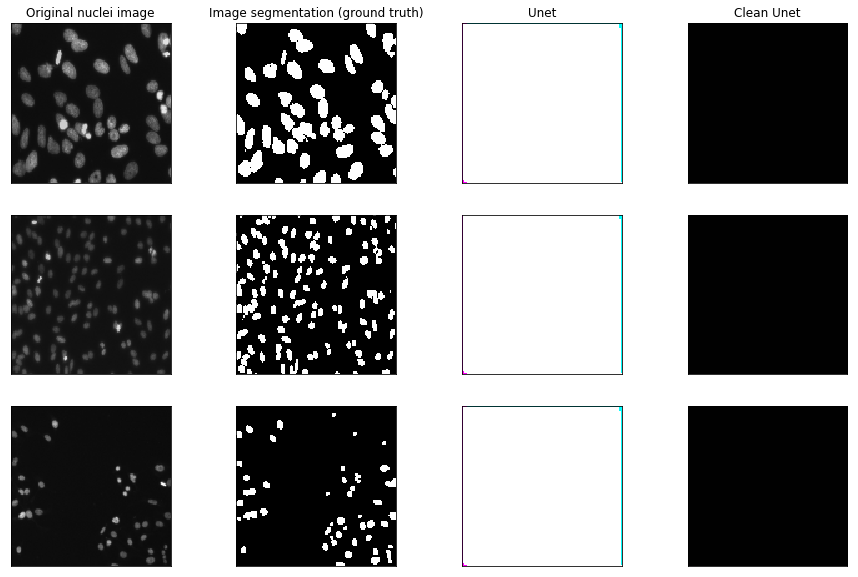

In [118]:
f, axarr = predict_segmentetion_plot(model_name = "Unet")